# Introduction
This notebook contains two main parts.
1. Simulation using the expression assuming normal incidence of a beam, using the expression provided by one of the cited publications.
2. Simulation using amplitudes from the approximate generalized grating equation, to allow for non-normal incidence.

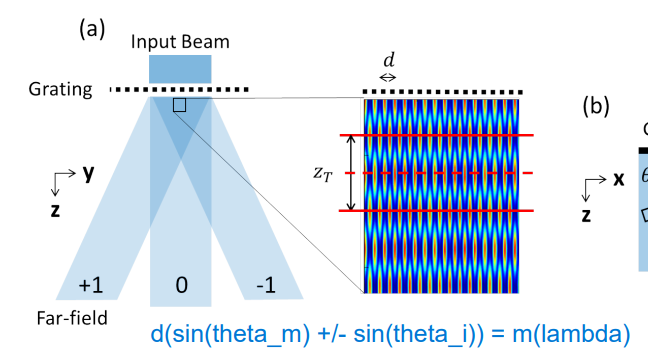

# Normal Incidence

Prof. Keathley mentioned that, instead of doing the entire diffractive optics simulation of the grating like we did with WPM or using something like rigorous coupled wave analysis, we can expect the output to be dominated by the 0th, and 1st order diffracted beams, and if the input is close enough to a plane wave, approximate the output as a sum of three plane waves. According to Han (2016), this has the functional form:

$$I(x,z)\propto A_0^2 + A_1^2 + A_{-1}^2 + 2A_1A_{-1}\cos(4\pi x/d) + 2A_0(A_1+A_{-1})\cos(2\pi x/d)\cos(2\pi z/z_T) + 2A_0(A_1-A_{-1})\sin(2\pi x/d)\sin(2\pi z/z_T)$$

Depending on our sensor tilt and pixel pitch and size, we integrate over a certain $x$ and $z$ range of this pattern when we read out the intensity. I don't care about normalization in this process; we just want to see what the pattern looks like.

In [439]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure

# length units in microns
wavelen = 0.633
gratinglen = 1.2

samplelen = 0.112 * 2 # CHANGE THIS TO CHANGE SIZE OF PIXELS
# samplelen = 0.36
# samplelen = 0.24
samples_per_pixel = 5 # product with samplelen is the micron pixel pitch, get samples_per_pixel^2 samples per pixel

z_T = wavelen / (1 - np.sqrt(1 - (wavelen**2 / gratinglen**2)))
print(z_T)

# nxpix = 3496
# nypix = 4656
nxpix = 50
nypix = 2400

# relative amplitudes
A0 = 1.0
A1 = 0.5
A_1 = 0.4

# factors in I(x,z) (note I ignore the A_0^2 + A_1^2 + A_-1^2 term that only contributes to the zero frequency)
factor1 = 2 * A1 * A_1
factor2 = 2*A0*(A1+A_1)
factor3 = 2*A0*(A1-A_1)

# angle of sensor
theta = 20 * np.pi/180

# (erroneous) rotation of sensor
phi = 0.01 * np.pi/180

# fractional x-shift of sensor
dx = 0.111

4.207518552999907


We're going to compute $I(x,z)$ on the sensor plane, sampling a number of points per pixel of the sensor and averaging them. Our geometry is as follows: The grating sits in the $x-y$ plane. Its direction of periodicity is $x$, and the grooves of the grating run along $y$, thus the diffracted beams are angled out in the $x-z$ plane. At zero angle, the sensor also sits in the $x-y$ plane. As we increase angle, the sensor is tilted around the $x$-axis. One edge of the sensor remains in contact with the grating at the $y$-axis. As a result, the range of $x$ values sampled is always the same, but the $z$ value goes as

$$z_{px} = y_{0,px}\sin(\theta)$$

where $y_{0,px}$ is the original (untilted) $y$ coordinate of the pixel. Thus for richer Fourier transforms the $y$ dimension of the sensor is chosen to be the longer one.

In [440]:
def DoRotation(xx, yy, phi=0):
    """Rotate meshgrid arrays by phi radians."""

    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(phi),  np.sin(phi)],
                          [-np.sin(phi), np.cos(phi)]])

    return np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([xx, yy]))

# Initialize the positions of samples with zero tilt
nsx = nxpix * samples_per_pixel
nsy = nypix * samples_per_pixel

xvals = np.linspace(0, nsx * samplelen, nsx)
yvals = np.linspace(0, nsy * samplelen, nsy)
xx, yy = np.meshgrid(xvals, yvals)

# perform a rotation of the sensor around z (an example imperfection)
xx, yy = DoRotation(xx, yy, phi)

# perform the tilt of the sensor around x
zz = yy * np.sin(theta)
yy = yy * np.cos(theta)

# perform a shift of the sensor along x (an example imperfection)
xx = xx + samplelen * samples_per_pixel * dx

In [441]:
# At each of the sampled points, compute I(x,z)
I = factor1 * np.cos(4*np.pi*xx / gratinglen) + factor2 * np.cos(2*np.pi*xx / gratinglen) * np.cos(2*np.pi*zz / z_T) + factor3 * np.sin(2*np.pi*xx / gratinglen) * np.sin(2*np.pi*zz / z_T)
# Downsample back into nxpix by nypix by sum
sum_I = skimage.measure.block_reduce(I, (samples_per_pixel, samples_per_pixel), np.sum)

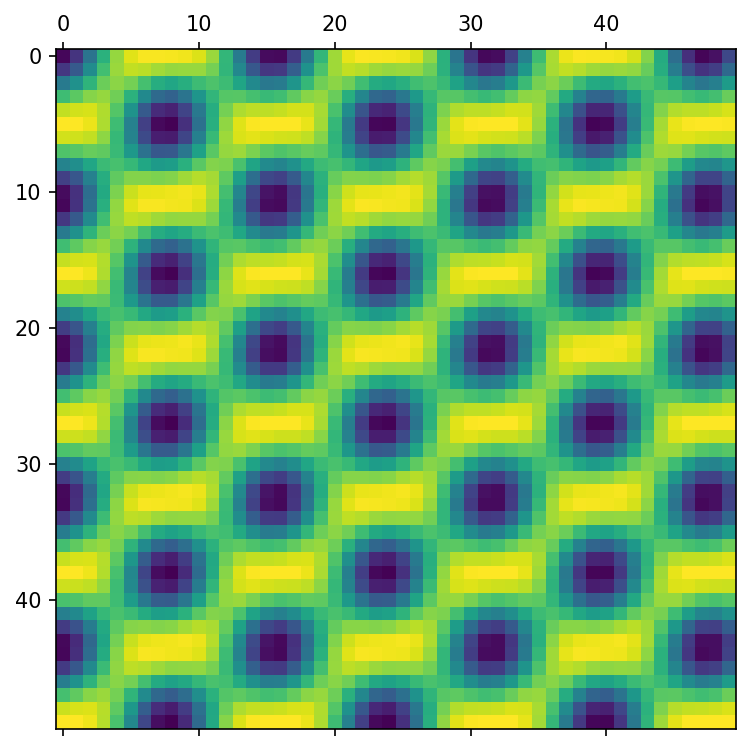

In [442]:
fig, ax = plt.subplots(figsize=(6,6), dpi=150)
ax.matshow(sum_I[0:50, 0:50])
#plt.savefig('badpitchshift')
plt.show()

### Column-wise Fourier Transforms
This is what's used in the paper to estimate frequencies. Our rows (indexed along first dimension) are in the x-direction, in-plane to the grating. The columns (second dimension) represent the z-direction as sampled by the tilted sensor.

Recall that in this non-paraxial limit, with $\lambda\approx d$ of the grating, we have

$$z_T = \frac{\lambda}{1-\sqrt{1-\frac{\lambda^2}{d^2}}}$$

(2400, 50)


C:\Users\jade2\AppData\Local\Temp\ipykernel_21744\398831284.py:11: RuntimeWarning: divide by zero encountered in divide
  Talbot_lengths = 1 / frequencies
C:\Users\jade2\AppData\Local\Temp\ipykernel_21744\398831284.py:14: RuntimeWarning: invalid value encountered in divide
  wavelengths = 2 * Talbot_lengths * gratinglen**2 / (Talbot_lengths**2 + gratinglen**2)


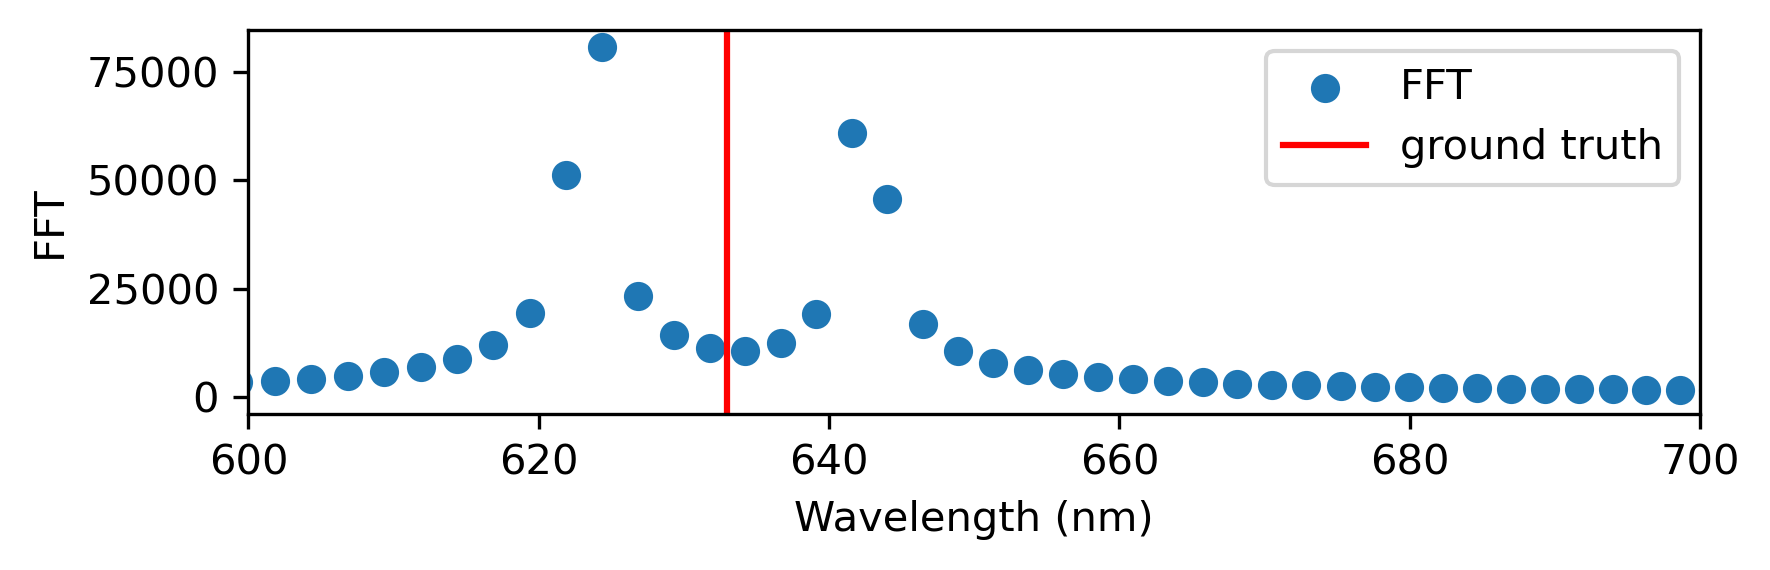

In [428]:
# Compute the FFT per column
FFT = np.zeros(sum_I.shape[0])
print(sum_I.shape)
for i in range(sum_I.shape[1]):
    signal = sum_I[:, 1]
    fft = np.fft.fft(signal)
    FFT = FFT + fft

sampling_period = samplelen * samples_per_pixel * np.sin(theta)
frequencies = np.fft.fftfreq(FFT.shape[0], sampling_period) # spatial frequency in 1/microns of the Talbot pattern
Talbot_lengths = 1 / frequencies

# Convert spatial frequency into wavelength of incident light
wavelengths = 2 * Talbot_lengths * gratinglen**2 / (Talbot_lengths**2 + gratinglen**2)

result = np.abs(FFT)
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(wavelengths * 1000, result, label='FFT')
plt.xlim((600, 700))
plt.axvline(wavelen * 1000, color='red', label='ground truth')
plt.xlabel("Wavelength (nm)")
plt.ylabel("FFT")
plt.legend()
plt.tight_layout()

#plt.savefig("01degshift")

plt.show()

### What happens if we tilt the sensor in the other direction?
Instead of tilting around $x$ axis for a grating with periodicity in $x$, what if we tilt around the $y$ direction? SPOILER: nothing pretty from the direct FFT.

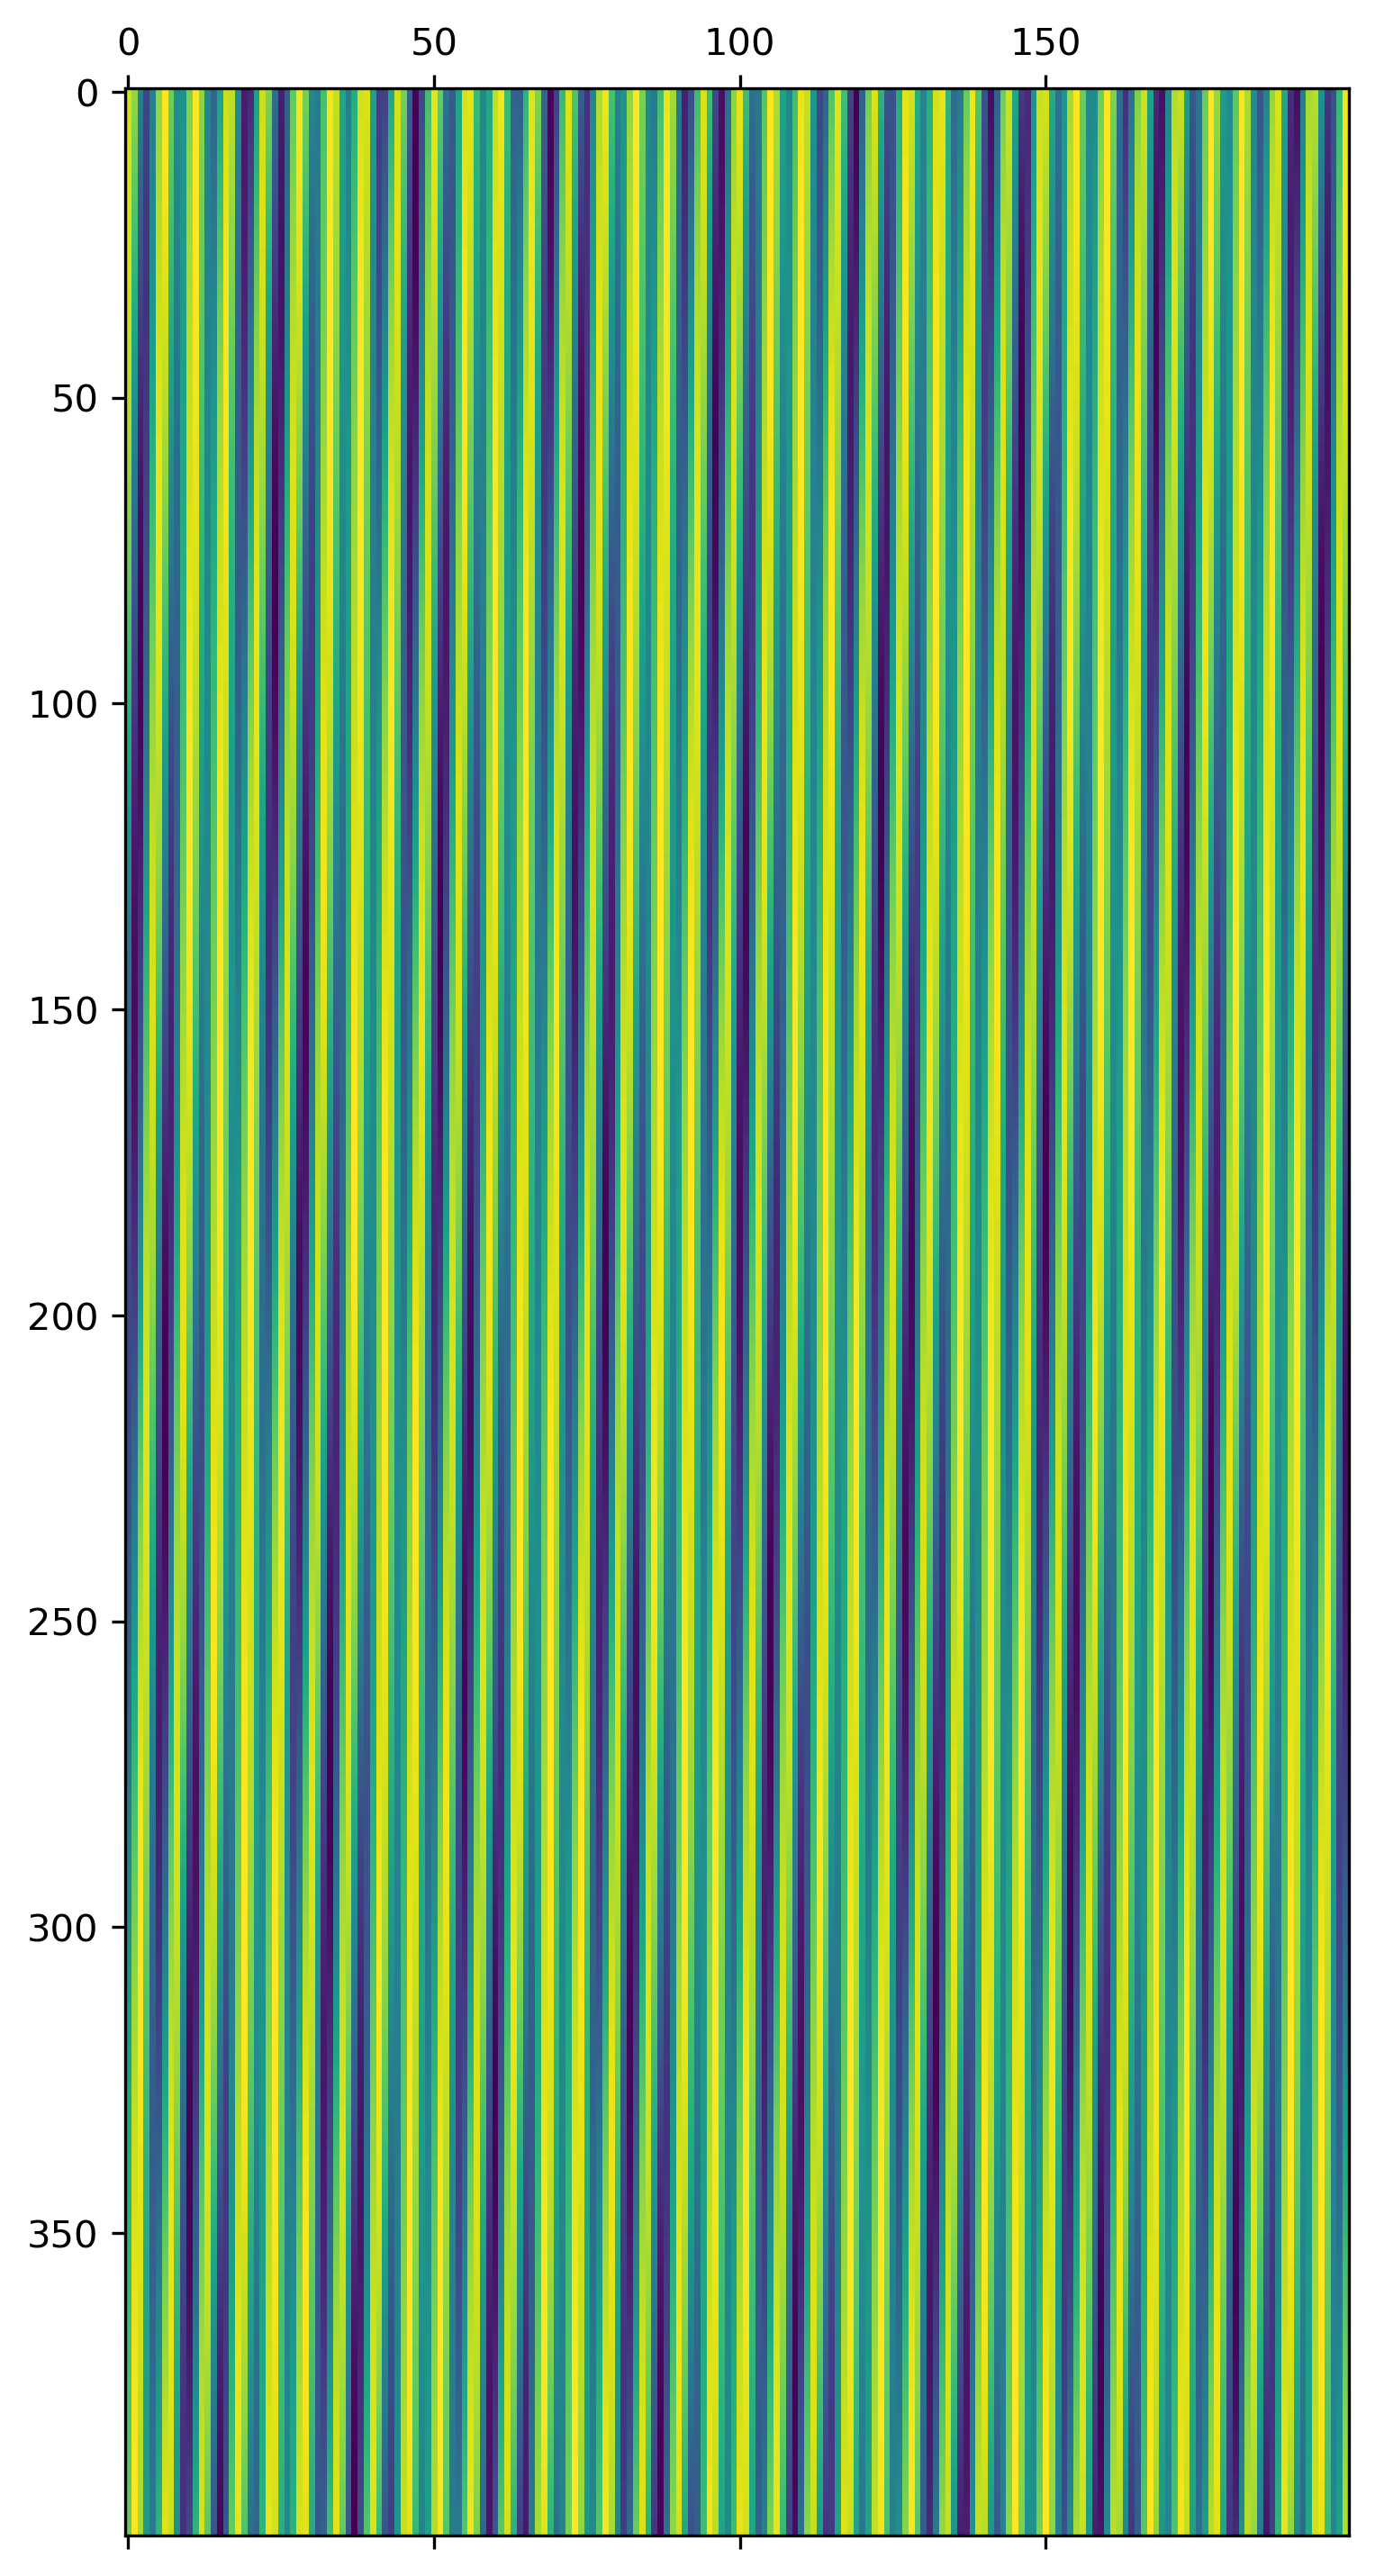

In [32]:
# angle of sensor
theta = 20 * np.pi/180

# (erroneous) rotation of sensor
phi = 0.1 * np.pi/180

#####

# Initialize the positions of samples with zero tilt
nsx = nxpix * samples_per_pixel
nsy = nypix * samples_per_pixel

xvals = np.linspace(0, nsx * samplelen, nsx)
yvals = np.linspace(0, nsy * samplelen, nsy)
xx, yy = np.meshgrid(xvals, yvals)

# perform a rotation of the sensor around z (an example imperfection)
xx, yy = DoRotation(xx, yy, phi)

# perform the tilt of the sensor around y
zz = xx * np.sin(theta)
xx = xx * np.cos(theta)

# At each of the sampled points, compute I(x,z)
I = factor1 * np.cos(4*np.pi*xx / gratinglen) + factor2 * np.cos(2*np.pi*xx / gratinglen) * np.cos(2*np.pi*zz / z_T) + factor3 * np.sin(2*np.pi*xx / gratinglen) * np.sin(2*np.pi*zz / z_T)
# Downsample back into nxpix by nypix by sum
sum_I = skimage.measure.block_reduce(I, (samples_per_pixel, samples_per_pixel), np.sum)

fig, ax = plt.subplots(figsize=(12,12), dpi=300)
#ax.matshow(sum_I[:, 0:1])
ax.matshow(sum_I)
plt.show()

(400, 200)


C:\Users\jade2\AppData\Local\Temp\ipykernel_16112\186185610.py:11: RuntimeWarning: divide by zero encountered in divide
  Talbot_lengths = 1 / frequencies
C:\Users\jade2\AppData\Local\Temp\ipykernel_16112\186185610.py:14: RuntimeWarning: invalid value encountered in divide
  wavelengths = 2 * Talbot_lengths * gratinglen**2 / (Talbot_lengths**2 + gratinglen**2)


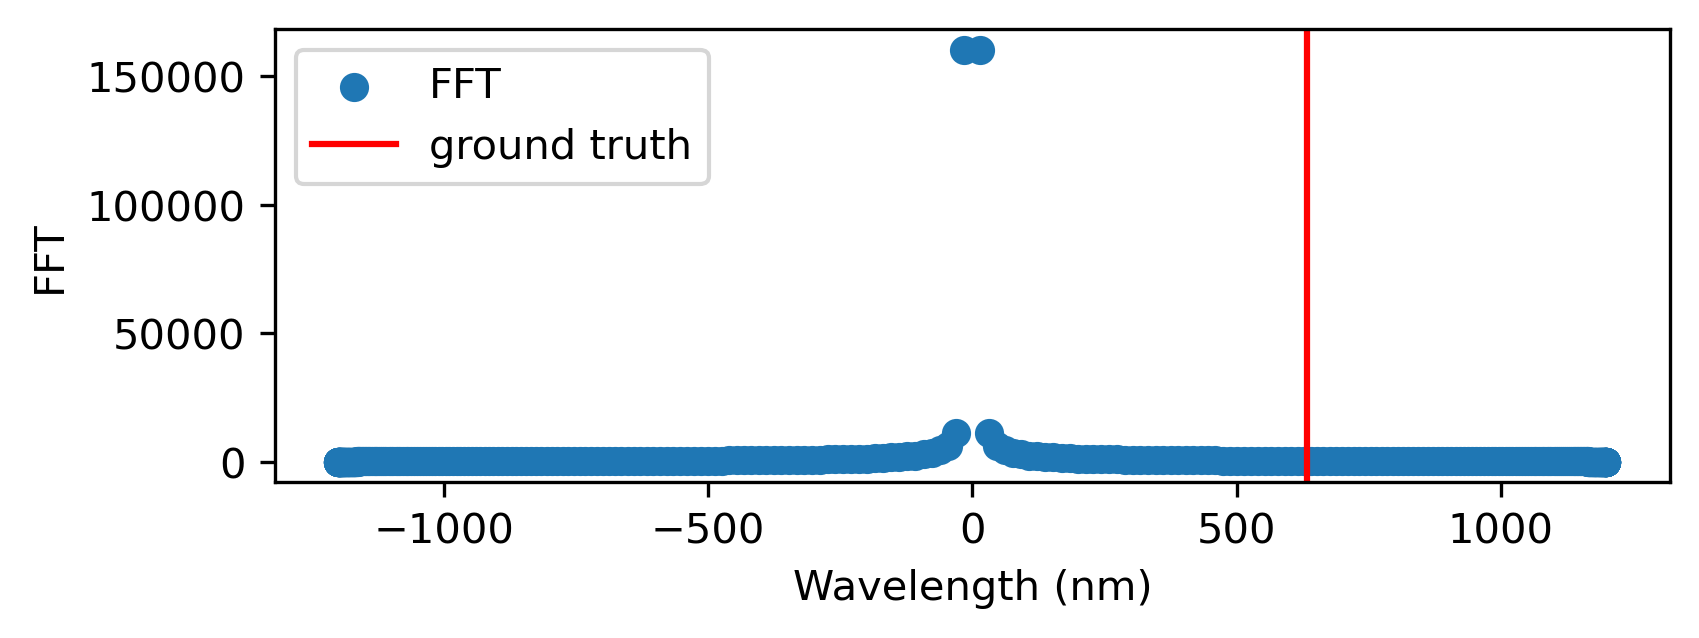

In [34]:
# Compute the FFT per row
FFT = np.zeros(sum_I.shape[0])
print(sum_I.shape)
for i in range(sum_I.shape[1]):
    signal = sum_I[:, 1]
    fft = np.fft.fft(signal)
    FFT = FFT + fft

sampling_period = samplelen * samples_per_pixel * np.sin(theta)
frequencies = np.fft.fftfreq(FFT.shape[0], sampling_period) # spatial frequency in 1/microns of the Talbot pattern
Talbot_lengths = 1 / frequencies

# Convert spatial frequency into wavelength of incident light
wavelengths = 2 * Talbot_lengths * gratinglen**2 / (Talbot_lengths**2 + gratinglen**2)

result = np.abs(FFT)
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(wavelengths * 1000, result, label='FFT')
#plt.xlim((400, 1000))
plt.axvline(wavelen * 1000, color='red', label='ground truth')
plt.xlabel("Wavelength (nm)")
plt.ylabel("FFT")
plt.legend()
plt.show()

(400, 200)


C:\Users\jade2\AppData\Local\Temp\ipykernel_16112\440747670.py:11: RuntimeWarning: divide by zero encountered in divide
  Talbot_lengths = 1 / frequencies
C:\Users\jade2\AppData\Local\Temp\ipykernel_16112\440747670.py:14: RuntimeWarning: invalid value encountered in divide
  wavelengths = 2 * Talbot_lengths * gratinglen**2 / (Talbot_lengths**2 + gratinglen**2)


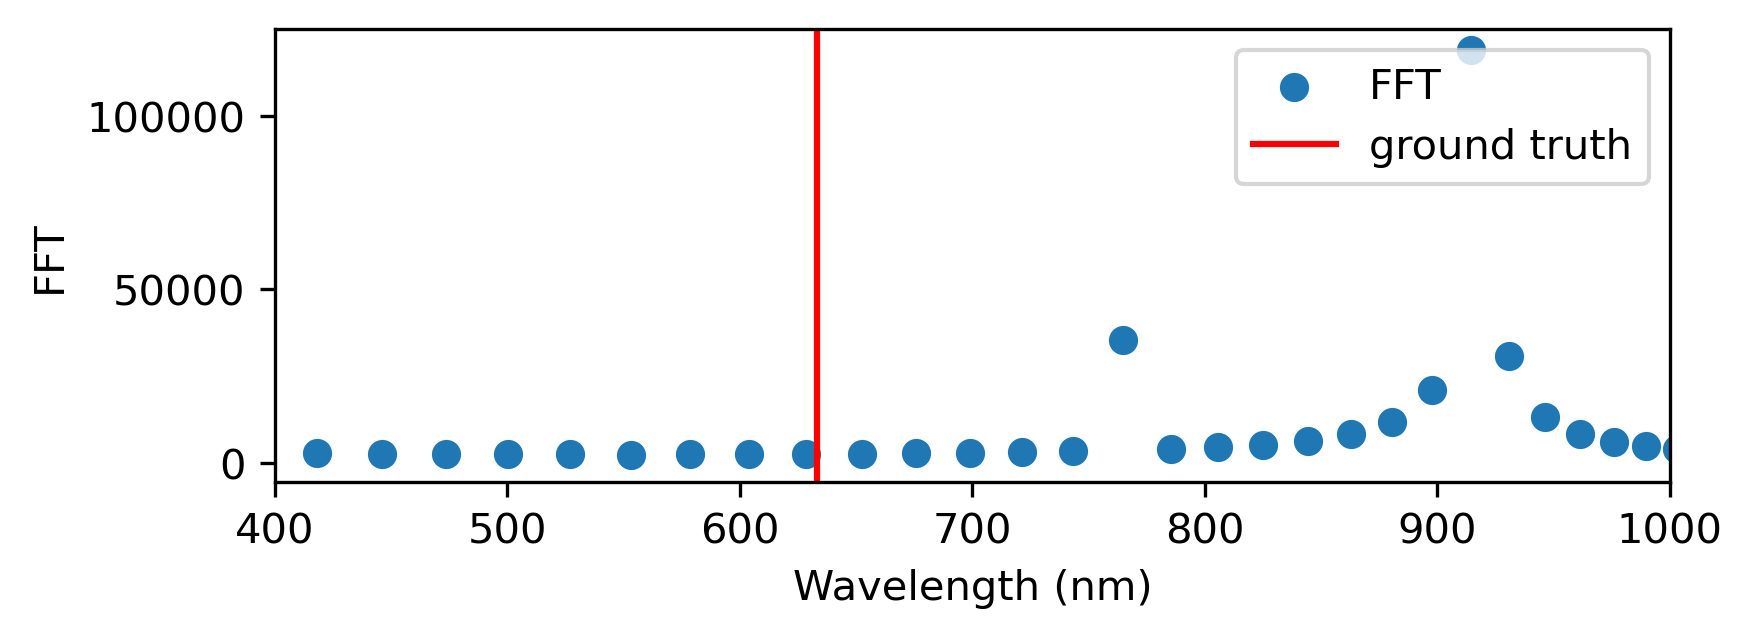

In [35]:
# Compute the FFT per column (shouldn't theoretically give anything useful)
FFT = np.zeros(sum_I.shape[1])
print(sum_I.shape)
for i in range(sum_I.shape[0]):
    signal = sum_I[1, :]
    fft = np.fft.fft(signal)
    FFT = FFT + fft

sampling_period = samplelen * samples_per_pixel * np.sin(theta)
frequencies = np.fft.fftfreq(FFT.shape[0], sampling_period) # spatial frequency in 1/microns of the Talbot pattern
Talbot_lengths = 1 / frequencies

# Convert spatial frequency into wavelength of incident light
wavelengths = 2 * Talbot_lengths * gratinglen**2 / (Talbot_lengths**2 + gratinglen**2)

result = np.abs(FFT)
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(wavelengths * 1000, result, label='FFT')
plt.xlim((400, 1000))
plt.axvline(wavelen * 1000, color='red', label='ground truth')
plt.xlabel("Wavelength (nm)")
plt.ylabel("FFT")
plt.legend()
plt.show()

# Generalized Grating Equation
In general, the diffracted waves follow directions according to the generalized grating equation (see Wikipedia for "diffraction grating") which says,
$$\sin\theta_i - \sin\theta_m = \frac{m\lambda}{d\sin\gamma}$$

where $\theta_m$ is the $m$th order diffraction angle, $\theta_i$ is the angle of incidence relative to the grating normal in a 2D picture, and $\gamma$ is the 3D angle between the grooves of the grating and the incidence vector.

It's dubious as to whether this is correct, as I couldn't find a source, but the behavior seems vaguely consistent with another publication I saw, but does not account for what things look like in 3D, which is important for our simulated images. For small $\gamma$ it should be fine, though.

Here, we'll compute an intensity field resulting from these plane waves, and repeat the sampling process from before. This should give us an idea as to how sensitive the measurements are to non-normal incidence.

-31.25001382888191
32.427130320570036


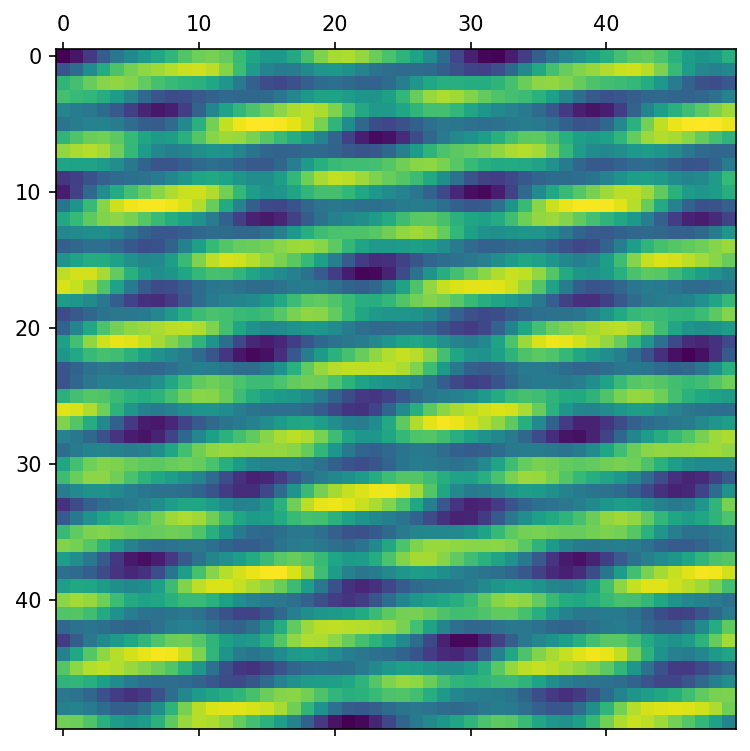

In [467]:
# REMARK: run the sensor parameters cell and the cell that defines DoRotation first

# incidence parameters
thetai = 0.5 * np.pi/180
gamma = 0 * np.pi/180 + np.pi/2

phi0 = 0
phi1 = 0
phi_1 = 0

# compute the angles of diffracted beams
theta0 = thetai
theta1 = np.arcsin(np.sin(thetai) - (wavelen/(gratinglen*np.sin(gamma))))
theta_1 = np.arcsin(np.sin(thetai) + (wavelen/(gratinglen*np.sin(gamma))))

print(theta1 * 180/np.pi)
print(theta_1 * 180/np.pi)

# convert into wavevectors in x-z plane
k = 2 * np.pi / wavelen # um^-1
k0z = k * np.cos(theta0)
k0x = k * np.sin(theta0)

k1z = k * np.cos(theta1)
k1x = k * np.sin(theta1)

k_1z = k * np.cos(theta_1)
k_1x = k * np.sin(theta_1)

# produce the amplitudes due to each beam at each xx zz point sampled
order0 = A0 * np.sin(k0x*xx + k0z*zz + phi0)
order1 = A1 * np.sin(k1x*xx + k1z*zz + phi1)
order_1 = A1 * np.sin(k_1x*xx + k_1z*zz + phi_1)

# and then interfere them
tot_amplitudes = order0 + order1 + order_1

# square to produce amplitudes
tot_intensities = tot_amplitudes ** 2

# downsample into the image
pixel_values = skimage.measure.block_reduce(tot_intensities, (samples_per_pixel, samples_per_pixel), np.sum)

# display the image
fig, ax = plt.subplots(figsize=(6,6), dpi=150)
ax.matshow(pixel_values[0:50, 0:50])
plt.show()

(2400, 50)


C:\Users\jade2\AppData\Local\Temp\ipykernel_21744\55758741.py:12: RuntimeWarning: divide by zero encountered in divide
  Talbot_lengths = 1 / frequencies
C:\Users\jade2\AppData\Local\Temp\ipykernel_21744\55758741.py:15: RuntimeWarning: invalid value encountered in divide
  wavelengths = 2 * Talbot_lengths * gratinglen**2 / (Talbot_lengths**2 + gratinglen**2)


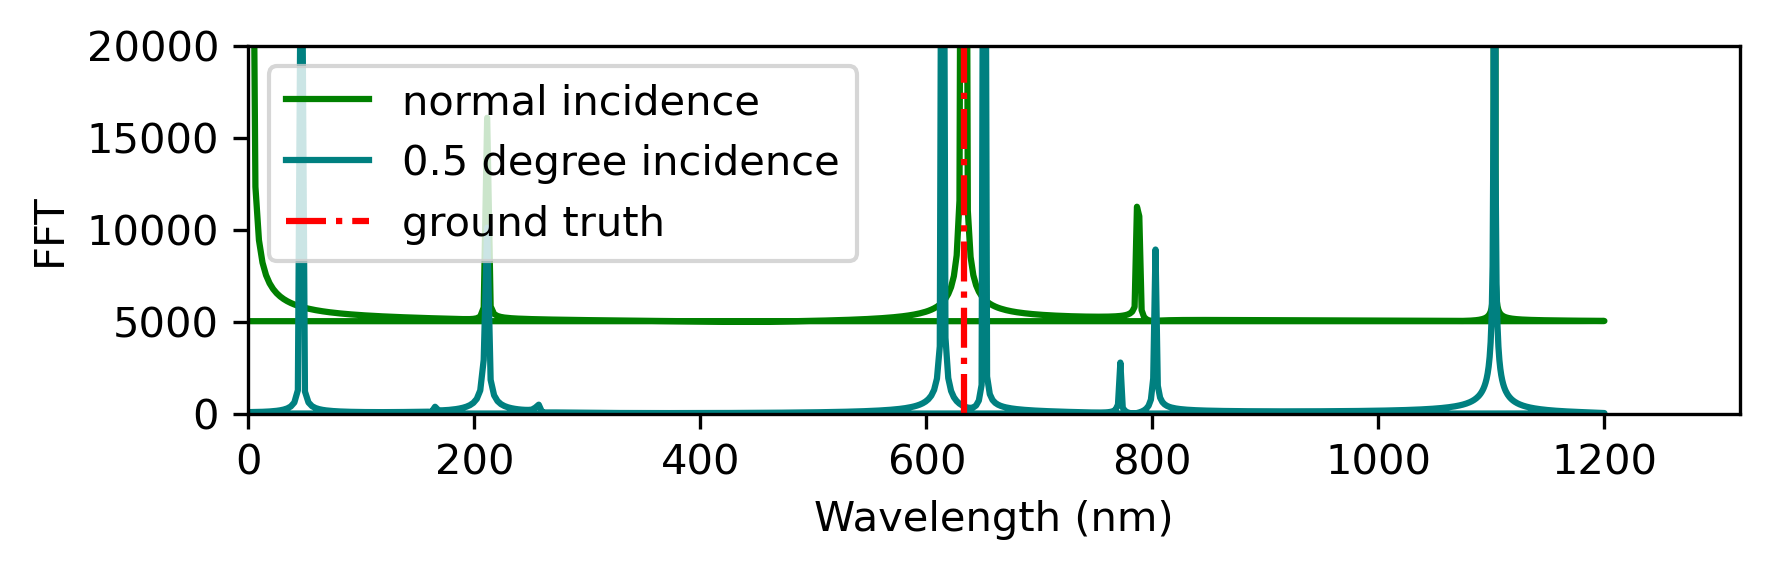

In [469]:
# perform Fourier transform and compute wavelengths as before

FFT = np.zeros(pixel_values.shape[0])
print(pixel_values.shape)
for i in range(pixel_values.shape[1]):
    signal = pixel_values[:, 1]
    fft = np.fft.fft(signal)
    FFT = FFT + fft

sampling_period = samplelen * samples_per_pixel * np.sin(theta)
frequencies = np.fft.fftfreq(FFT.shape[0], sampling_period) # spatial frequency in 1/microns of the Talbot pattern
Talbot_lengths = 1 / frequencies

# Convert spatial frequency into wavelength of incident light
wavelengths = 2 * Talbot_lengths * gratinglen**2 / (Talbot_lengths**2 + gratinglen**2)

result = np.abs(FFT)
plt.figure(figsize=(6,2), dpi=300)
plt.plot(wavelengths * 1000, prev + 5000, color='g', label='normal incidence')
plt.plot(wavelengths * 1000, result, color='teal', label='0.5 degree incidence')
plt.xlim(0)
plt.ylim(0, 20000)
plt.axvline(wavelen * 1000, color='red', linestyle='-.', label='ground truth')
plt.xlabel("Wavelength (nm)")
plt.ylabel("FFT")
plt.legend()
plt.tight_layout()

plt.savefig('incidence05')
plt.show()

In [451]:
# hack to store previous results
prev = result